# Final Project for Supervised Machine Learning Regression

## Supervised Machine Learning Regression with Car details from Car Dekho

[Data Source](https://www.kaggle.com/nehalbirla/vehicle-dataset-from-cardekho?select=CAR+DETAILS+FROM+CAR+DEKHO.csv)

<br />
<hr />

    Mustafa Tayyip BAYRAM
     December 22, 2021
<hr />
<br />

## Data Set Contents
As columns implies, contents is extremely clear.
>- Number of Instances: 4340
>- Number of Attributes: 8 including the class attributes
>- Columns of data set
        name
        year
        selling_price
        km_driven
        fuel
        seller_type
        transmission
        Owner



## Notebook Contents
>1-2. Importing Packages and Reading
>3. Data Examination and Cleaning
>4. Exploratory Data Analysis
>5. Training Model

- Model Variations
- Cross-validation and Regularization
- Predict on the test set




### 1. Packages

In [57]:
%pylab inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

# Mute the setting with a copy warnings
pd.options.mode.chained_assignment = None

# Mute the sklearn warning about regularization
import warnings
warnings.filterwarnings('ignore', module='sklearn')

Populating the interactive namespace from numpy and matplotlib


### 2. Read Data

In [58]:
# Loading dataset
filepath = 'CAR DETAILS FROM CAR DEKHO.csv'
df = pd.read_csv(filepath)
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [59]:
df.shape

(4340, 8)

### 3. Data Examination and Cleaning

In [60]:
# Drop duplicates and check the new data dimensions
df = df.drop_duplicates(keep='first').reset_index(drop='True')
df.shape

(3577, 8)

In [61]:
# Splitting value and pred cols.
y_col = 'selling_price'
X = df.drop(y_col, axis=1)
y = df[y_col]

In [62]:
# Split the data to use as training set and test set.
from sklearn.model_selection import train_test_split
X_training_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=47)
print(f'Training and val set size (X): {X_training_val.shape}')
print(f'Test set size (XT): {X_test.shape}')
print(f"Training and val set size (Y): {y_train_val.shape}")
print(f"Test set size (YT): {y_test.shape}")

Training and val set size (X): (2861, 7)
Test set size (XT): (716, 7)
Training and val set size (Y): (2861,)
Test set size (YT): (716,)


In [63]:
X_train, X_val, y_train, y_val = train_test_split(X_training_val, y_train_val, test_size=0.25, random_state=29)
print(f'Training set size (X): {X_train.shape}')
print(f'Training set size (y): {y_train.shape}')
print(f'Validation set size (X): {X_val.shape}')
print(f'Validation set size (y): {y_val.shape}')

Training set size (X): (2145, 7)
Training set size (y): (2145,)
Validation set size (X): (716, 7)
Validation set size (y): (716,)


### 4. Exploratory Data Analysis

In [64]:
X_train.head()
X_train.info()
X_train.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2145 entries, 1930 to 2248
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   name          2145 non-null   object
 1   year          2145 non-null   int64 
 2   km_driven     2145 non-null   int64 
 3   fuel          2145 non-null   object
 4   seller_type   2145 non-null   object
 5   transmission  2145 non-null   object
 6   owner         2145 non-null   object
dtypes: int64(2), object(5)
memory usage: 134.1+ KB


,year,km_driven
count,2145.000000,2145.000000
mean,2012.872261,70230.586946
std,4.261891,49131.166921
min,1996.000000,1.000000
25%,2010.000000,40000.000000
50%,2013.000000,62000.000000
75%,2016.000000,90000.000000
max,2020.000000,806599.000000


In [65]:
from datetime import date
current_date = date.today()
# Adding a new feature age and remove year
X_train = X_train[ X_train['year'] <= current_date.year]
X_train['age'] = current_date.year - X_train['year']
X_train = X_train.drop(['year'], axis=1)

In [66]:
X_train.head()

,name,km_driven,fuel,seller_type,transmission,owner,age
1930,Hyundai Grand i10 CRDi Magna,60000,Diesel,Individual,Manual,Second Owner,6
1497,Toyota Innova 2.5 G (Diesel) 8 Seater BS IV,300000,Diesel,Individual,Manual,First Owner,15
82,Fiat Avventura MULTIJET Emotion,53000,Diesel,Individual,Manual,Second Owner,6
2036,Toyota Corolla H3,120000,Petrol,Individual,Automatic,Second Owner,18
1650,Hyundai Creta 1.4 CRDi Base,70000,Diesel,Individual,Manual,Second Owner,3


In [67]:
# Determine columns by data types
category_mask = (X_train.dtypes == object)
num_mask = (X_train.dtypes == np.float64) | (X_train.dtypes == np.int64)

category_cols = X_train.columns[category_mask].tolist()
num_cols = X_train.columns[num_mask].tolist()

print(f'Categorical columns: {category_cols}')
print(f'Numerical columns: {num_cols}')


Categorical columns: ['name', 'fuel', 'seller_type', 'transmission', 'owner']
Numerical columns: ['km_driven', 'age']


#### Analyzing Numerical Features

In [68]:
# Create a plotting function
def hist_loop(df: pd.DataFrame,
              rows: int,
              cols: int,
              figsize: tuple):
    """
    Returns multiple histograms as subplots
    """
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    for i, ax in enumerate(axes.flatten()):
        if i < len(df.columns):
            df[sorted(df.columns)[i]].plot.hist(bins=30, ax=ax)
            ax.set_title(f'{sorted(df.columns)[i]} distribution')
            ax.tick_params(axis='x')
            ax.tick_params(axis='y')
            ax.get_yaxis().get_label().set_visible(False)
        else:
            fig.delaxes(ax=ax)
    fig.tight_layout()

In [69]:
X_train.shape

(2145, 7)

In [70]:
df_train = X_train
df_train['selling_price'] = y_train
df_num_cols = num_cols.copy()
df_num_cols.append('selling_price')
df_num_cols


['km_driven', 'age', 'selling_price']

In [71]:

df_train[df_num_cols]

,km_driven,age,selling_price
1930,60000,6,300000
1497,300000,15,229999
82,53000,6,350000
2036,120000,18,95000
1650,70000,3,950000
...,...,...,...
1815,44000,4,509999
1565,180000,8,150000
871,68000,3,4000000
3136,50000,4,320000


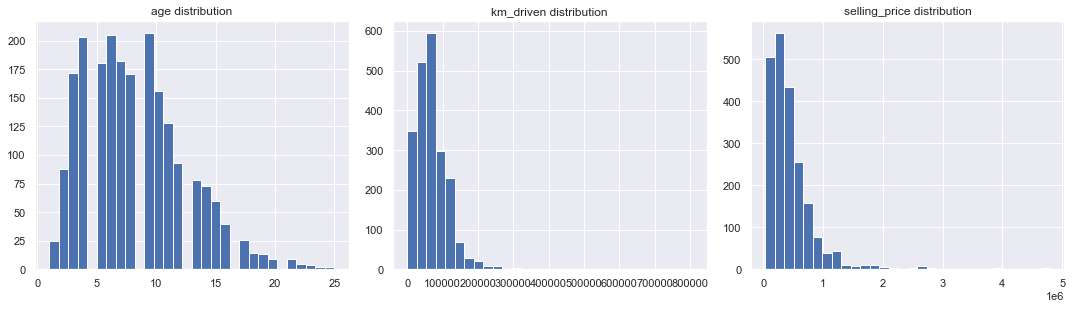

In [72]:
# Plot all numerical features
hist_loop(df=df_train[df_num_cols],
        rows=2,
        cols=3,
        figsize=(15,8))

In [73]:
# Checking skewness of all numerical features
def skew_df(df: pd.DataFrame, skew_limit: float) -> pd.DataFrame:
    # Define a limit above that we will transform
    skew_vals = df.skew()

    # Showing the skewed cols
    skew_cols = (skew_vals
                 .sort_values(ascending=False)
                 .to_frame('Skew')
                 .query('abs(Skew) > {}'.format(skew_limit)))
    return skew_cols
skew_cols = skew_df(df_train[df_num_cols], 0.75)
skew_cols

,Skew
selling_price,4.097210
km_driven,3.137131
age,0.751290


In [74]:
X_train_sqrt = X_train[num_cols].copy()
for col in list(skew_cols.index):
    if col != 'selling_price':
        X_train_sqrt[col] = X_train_sqrt[col].apply(np.sqrt)

# Check again
skew_df(X_train_sqrt, 0.75)

,Skew


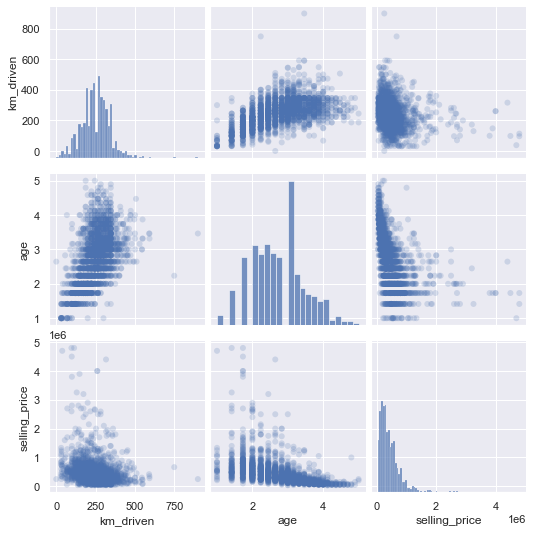

In [75]:
# Pair plot of transformed features and the target

sns.pairplot(X_train_sqrt.join(y_train), plot_kws=dict(alpha=.2, edgecolor='none'))

As you can see, there is a linear relationship with age and selling_price.
Age and km_driven has positive relationship
Multicollinearity


In [76]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def Calculate_vif(X):
    # Calculating VIF
    vif = pd.DataFrame()
    vif['variables'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

Calculate_vif(X_train_sqrt)

,variables,VIF
0,km_driven,11.963502
1,age,11.963502


Variables have high multicollinearity. This problem can be solve by regularization later.

### Categorical Features

In [77]:
X_train.describe(include=object)

,name,fuel,seller_type,transmission,owner
count,2145,2145,2145,2145,2145
unique,1101,5,3,2,5
top,Maruti Swift Dzire VDI,Diesel,Individual,Manual,First Owner
freq,38,1075,1711,1965,1311


In [78]:
# Adding Brands of cars
X_train['brands'] = df['name'].str.split(' ').str[0]
X_train['brands']
df_train['brands'] =X_train['brands']


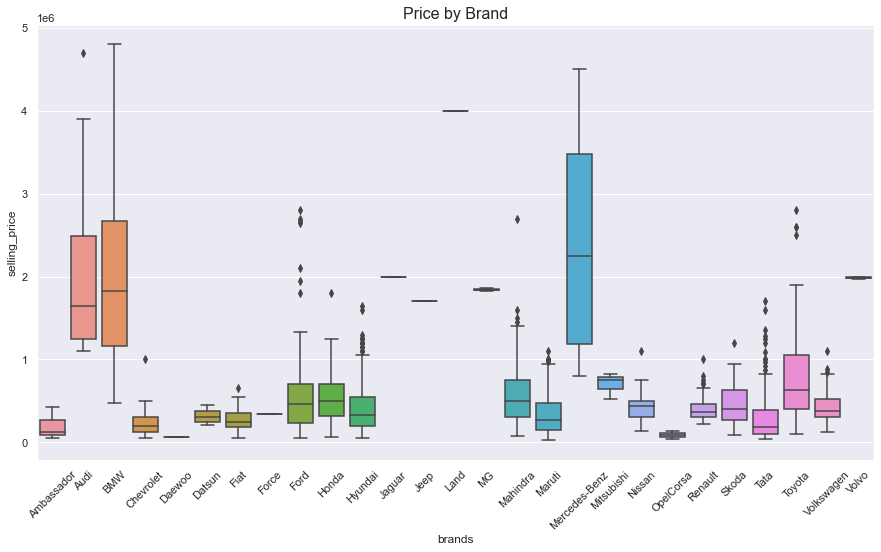

In [79]:
# Boxplot of model and price
fig, ax = plt.subplots(figsize=(15, 8))
order = sorted(list(X_train['brands'].unique()))
sns.boxplot(x='brands', y='selling_price', data=X_train, order=order, ax=ax)
plt.xticks(rotation=45)
plt.title('Price by Brand', fontsize=16)
plt.show()

In [80]:
list(X_train['transmission'].unique())

['Manual', 'Automatic']

In [81]:
list(X_train['fuel'].unique())

['Diesel', 'Petrol', 'LPG', 'CNG', 'Electric']

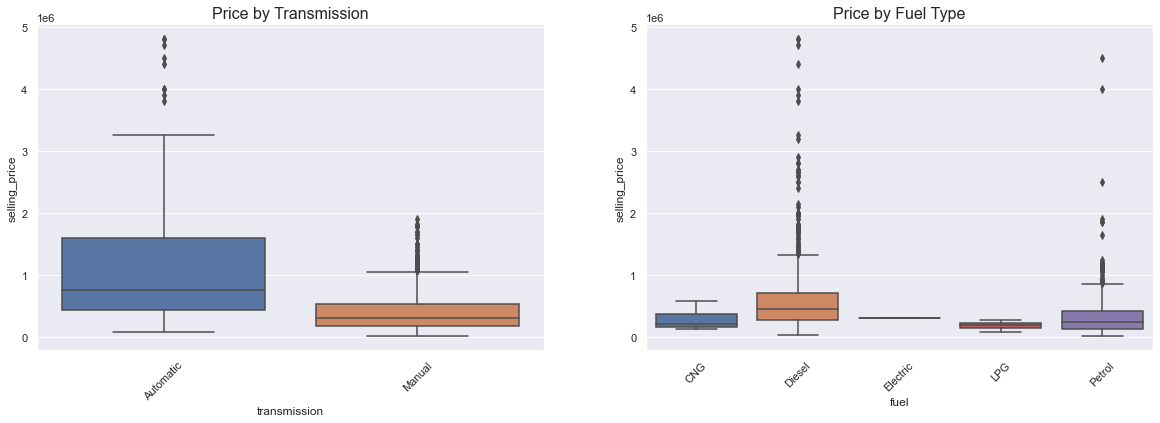

In [82]:
# Box plots of price and transmission/ fuel type
fig, ax= plt.subplots(1, 2, figsize=(20, 6))
trans_order = sorted(list(X_train['transmission'].unique()))
sns.boxplot(x='transmission', y='selling_price', data= X_train, order=trans_order, ax=ax[0])
ax[0].set_title('Price by Transmission', fontsize=16)
ax[0].tick_params('x', labelrotation=45)

fuel_order = sorted(list(X_train['fuel'].unique()))
sns.boxplot(x='fuel', y='selling_price', data=X_train, order=fuel_order, ax=ax[1])
ax[1].set_title('Price by Fuel Type', fontsize= 16)
ax[1].tick_params('x', labelrotation=45)
plt.show()

## 3. Model variations
We are going to perform different feature engineering in an order, then fit the linear regression after each engineering step. Root mean square errors are stored and compared.

In [83]:
# Copy the data from training and validation set
# Clean the data
df_train_val = X_training_val.join(y_train_val)
df_train_val.shape

(2861, 8)

In [84]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures

### Creating Linear Regression Class

In [85]:
# Create class for feature engineering and model fitting
class LR_model:
    # Default values
    target = 'selling_price'
    test_size = 0.25
    random_state = 29
    skew_cols = ['km_driven', 'age']

    def __init__(self, df):
        self.train, self.test = train_test_split(df, test_size=LR_model.test_size, random_state=LR_model.random_state, )
    def CleanData(self, df):
        df = df[df['year'] <= current_date.year]
        df['age'] = current_date.year - df['year']
        df = df.drop(['year'], axis = 1)
        # Adding Brands of cars
        df['brands'] = df['name'].str.split(' ').str[0]

        return df

    def OHE(self, X_train, X_test):
        # Performs one-hot encoding and drops the first category
        enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

        # Filter categorical features only
        X_train_cat = X_train.select_dtypes(include=['object'])
        X_test_cat = X_test.select_dtypes(include=['object'])

        # Fit OHE on training set
        # Transform both training set and test set
        X_train_enc = enc.fit_transform(X_train_cat)
        X_test_enc = enc.transform(X_test_cat)

        # Join dummy values with numerical features
        X_train_enc_df = pd.DataFrame(X_train_enc,
                                      index=X_train.index,
                                      columns=enc.get_feature_names(X_train_cat.columns.tolist()))
        X_train = X_train_enc_df.join(X_train.select_dtypes(exclude=['object']))

        # Drop one column of each category
        for col in X_train_cat.columns.tolist():
            category_cols = X_train.columns[X_train.columns.str.startswith(col)].tolist()
            if len(category_cols) > 1:
                X_train = X_train.drop(category_cols[0], axis=1)

        # Same steps for test set
        X_test_enc_df = pd.DataFrame(X_test_enc,
                                      index=X_test.index,
                                      columns=enc.get_feature_names(X_test_cat.columns.tolist()))
        X_test = X_test_enc_df.join(X_test.select_dtypes(exclude=['object']))

        # Drop one column of each category
        for col in X_test_cat.columns.tolist():
            category_cols = X_test.columns[X_test.columns.str.startswith(col)].tolist()
            if len(category_cols) > 1:
                X_test = X_test.drop(category_cols[0], axis=1)

        return X_train, X_test

    def SqrtTrans(self, X_train, X_test):
        # Applies square root transformation for skewed features.
        X_train[LR_model.skew_cols] = X_train[LR_model.skew_cols].apply(np.sqrt)
        X_test[LR_model.skew_cols] = X_test[LR_model.skew_cols].apply(np.sqrt)

        return X_train, X_test

    def Scale_X(self, X_train, X_test):
        # Applies standard scaling for all numerical features

        S = StandardScaler()

        # Filter number features only (excluding binary value)
        float_cols = X_train.columns[~X_train.isin([0, 1]).all()].tolist()

        # Fit features in training set and transform to test set
        X_train[float_cols] = S.fit_transform(X_train[float_cols])
        X_test[float_cols] = S.transform(X_test[float_cols])

        return X_train, X_test

    def AddPolyFeatures(self, X_train, X_test, degree=None):
        # Adds poly features into the dataset
        PF = PolynomialFeatures(degree=degree, include_bias=False)

        # Filter numerical features only (excluding binary values)
        float_cols = X_train.columns[~X_train.isin([0, 1]).all()].tolist()

        # Fit features in training set and transform to test set
        X_train_pf = PF.fit_transform(X_train[float_cols])
        X_test_pf = PF.transform(X_test[float_cols])

        # Add non-numerical features back into the transformed training set
        X_train_pf_df = pd.DataFrame(X_train_pf,
                                     index= X_train.index,
                                     columns=PF.get_feature_names(input_features=float_cols))

        X_train = X_train_pf_df.join(X_train[X_train.columns[~X_train.columns.isin(float_cols)].tolist()])

        # Ad non-numerical featrues back into the transformed test set
        X_test_pf_df = pd.DataFrame(X_test_pf,
                                    index=X_test.index,
                                    columns=PF.get_feature_names(input_features=float_cols))
        X_test = X_test_pf_df.join(X_test[X_test.columns[~X_test.columns.isin(float_cols)].tolist()])

        return X_train, X_test


    def RootMeanSqrtError(self, y_true, y_predict):
        return np.sqrt(mean_squared_error(y_true, y_predict))


    def FitModel(self, label=None,
                 encoding=False,
                 squareroot=False,
                 scaling=False,
                 polynomial=False,
                 degree=None):

        # Fits linear regression model and returns RMSE of training set and test set
        # Split data
        train, test = self.CleanData(self.train), self.CleanData(self.test)
        X_train, X_test = train.drop(LR_model.target, axis=1), test.drop(LR_model.target, axis=1)
        y_train, y_test = train[LR_model.target], test[LR_model.target]

        # Perform feature engineering
        if encoding:
            X_train, X_test = self.OHE(X_train, X_test)

        else:
            X_train, X_test = X_train.select_dtypes(exclude=['object']), X_test.select_dtypes(exclude=['object'])

        if squareroot:
            X_train, X_test = self.SqrtTrans(X_train, X_test)

        if scaling:
            X_train, X_test = self.Scale_X(X_train, X_test)

        if polynomial:
            X_train, X_test = self.AddPolyFeatures(X_train, X_test, degree)

        features_num = X_train.shape[1]
        # Fit model and predict the target
        LR = LinearRegression()
        LR.fit(X_train, y_train)
        y_train_pred = LR.predict(X_train)
        y_test_pred = LR.predict(X_test)

        # Compute Root Mean Squared Error and store in a dictionary
        rmse_train = self.RootMeanSqrtError(y_train, y_train_pred)
        rmse_test = self.RootMeanSqrtError(y_test, y_test_pred)

        r2score = {
            'Model' : label,
            'Number of Features' : features_num,
            'RMSE Train' : rmse_train,
            'RMSE Test' : rmse_test
        }
        return r2score

### Apply One-Hot Encoding

In [86]:
# Fit LR model in each set and print out R2 score
r2score_df = []   # Empty error list to create a data frame later.

# Fit non-encoded (ohc) data
not_encoded = LR_model(df).FitModel(label='Not Encoded(OHC)')

# Fit encoded data (ohc)
encoded = LR_model(df).FitModel(label='Encoded(OHC)', encoding=True)

# Print R2 Score table
r2score_df = pd.DataFrame.from_dict([not_encoded])
r2score_df = r2score_df.append(encoded, ignore_index=True)
r2score_df

,Model,Number of Features,RMSE Train,RMSE Test
0,Not Encoded(OHC),2,476823.969715,4.105871e+05
1,Encoded(OHC),1304,82677.006013,1.605189e+12


Encoded model that has encoded features performs better, which is understandable because it has more information to predict the target. RMSEs of test sets are slightly higher than training sets, which is expected.

### Apply Square Root Transformation

In [87]:
# Fit Non-encoded data
not_encoded_sqrtroot = LR_model(df).FitModel(label='Not Encoded + Square Root', squareroot=True)

# Fit Encodded data
encoded_sqrtroot = LR_model(df).FitModel(label='Encoded + Square Root', encoding=True, squareroot=True)

# Print r2 table
r2score_df = r2score_df.append([not_encoded_sqrtroot, encoded_sqrtroot], ignore_index=True)
r2score_df

,Model,Number of Features,RMSE Train,RMSE Test
0,Not Encoded(OHC),2,476823.969715,4.105871e+05
1,Encoded(OHC),1304,82677.006013,1.605189e+12
2,Not Encoded + Square Root,2,473673.443900,4.077402e+05
3,Encoded + Square Root,1304,74376.987854,5.692020e+13


Square Root Transformation improved all models. Encoded and Square Root Transformation applied model is the best now.

### Apply Standard Scaling
Scaling features is a preparation for regularization later. RMSEs of both training set and test set should be in the same interval.
From this point, I am going to use encoded data only.

In [88]:
# Fit encoded data
encoded_sqrtroot_scaled = LR_model(df).FitModel(label='Encoded(OHC) + Square Root + Scaled', encoding=True, squareroot=True, scaling=True)

# Print r2 table
r2score_df = r2score_df.append(encoded_sqrtroot_scaled, ignore_index=True)
r2score_df

,Model,Number of Features,RMSE Train,RMSE Test
0,Not Encoded(OHC),2,476823.969715,4.105871e+05
1,Encoded(OHC),1304,82677.006013,1.605189e+12
2,Not Encoded + Square Root,2,473673.443900,4.077402e+05
3,Encoded + Square Root,1304,74376.987854,5.692020e+13
4,Encoded(OHC) + Square Root + Scaled,1304,74394.010788,9.165199e+16


### Add Polynomial Features

As we saw in the pairplots, there is a polynomial relationship between the selling price and age. Try to add polynomial features to the latest model (encoded, square root transformed and scaled).

In [89]:
# Create empty r2 table
r2score_pf_df = pd.DataFrame(columns=['Model', 'Number of Features', 'RMSE Train', 'RMSE Test'])

# Iterate different degree, 1 to 10
for degree in list(range(1, 11)):
    r2_score = LR_model(df).FitModel(label='Degree ' + str(degree), encoding=True, scaling=True, polynomial=True, degree=degree)
    r2score_pf_df = r2score_pf_df.append(r2_score, ignore_index=True)

# Print r2 score
r2score_pf_df

,Model,Number of Features,RMSE Train,RMSE Test
0,Degree 1,1304,75897.954156,1.962429e+14
1,Degree 2,1307,73570.040376,3.614721e+15
2,Degree 3,1311,73185.630695,3.802166e+14
3,Degree 4,1316,72862.323151,7.339760e+13
4,Degree 5,1322,72684.913830,1.327380e+06
5,Degree 6,1329,72511.655526,3.306804e+12
6,Degree 7,1337,72312.464852,2.218051e+06
7,Degree 8,1346,72028.031053,4.019416e+09
8,Degree 9,1356,71613.002292,8.283269e+09
9,Degree 10,1367,71038.717398,4.364785e+11


The best model appears to be the third polynomial degree transformation. As the model becomes more complex, it begins to overfit at degree 4 and above.

### 4. Cross-Validation and Regularization
In this part, I am going to use cv to fit lr model again, and then try tuning the hyperparameter to find the right combination of alpha and polynomial degree for regularization.

In [90]:
# Import libraries
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn_pandas import DataFrameMapper, gen_features

In [91]:
# 5-fold cv
kf = KFold(shuffle=True, random_state=24, n_splits=5)

In [92]:
df

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner
...,...,...,...,...,...,...,...,...
3572,Hyundai i20 Magna 1.4 CRDi (Diesel),2014,409999,80000,Diesel,Individual,Manual,Second Owner
3573,Hyundai i20 Magna 1.4 CRDi,2014,409999,80000,Diesel,Individual,Manual,Second Owner
3574,Maruti 800 AC BSIII,2009,110000,83000,Petrol,Individual,Manual,Second Owner
3575,Hyundai Creta 1.6 CRDi SX Option,2016,865000,90000,Diesel,Individual,Manual,First Owner


In [93]:
df = df[df['year'] <= current_date.year]
df['age'] = current_date.year - df['year']
df = df.drop(['year'], axis=1)

df['brand'] = df['name'].str.split('').str[0]

X = df.drop('selling_price', axis=1)
y = df['selling_price']

In [94]:
# Create a class for data pipeline
class XPipe:
    # Skew features observed from the EDA
    skew_cols = ['km_driven', 'age']

    def __init__(self, X):
        self.category_cols = X.select_dtypes(include=['object']).columns.tolist()
        self.num_cols = X.select_dtypes(exclude=['object']).columns.tolist()

    def DropFirst(self, category_values):
        # Drops one category after OHC
        dummy_df = pd.DataFrame(category_values)
        dummy_df = dummy_df.drop(0, axis=1)

        return dummy_df.values

    def SqrtTrans(self, num_values):
        # Performs square root transformation to skewed features
        num_df = pd.DataFrame(num_values, columns=self.num_cols)
        num_df[XPipe.skew_cols] = num_df[XPipe.skew_cols].apply(np.sqrt)

        return num_df.values

    def ModelPipe(self, model, degree=2):
        # Returns a data pipeline
        category_list = [[col] for col in self.category_cols]
        category_features = gen_features(
            columns=category_list,
            classes=[{'class': OneHotEncoder, 'handle_unknown': 'ignore','sparse': False},
                     {'class': FunctionTransformer, 'func': self.DropFirst}]
        )
        mapper = DataFrameMapper((category_features) + [
            (self.num_cols, [FunctionTransformer(self.SqrtTrans),
                             StandardScaler(),
                             PolynomialFeatures(degree=degree, include_bias=False)])
        ])

        return make_pipeline(mapper, model)

In [95]:
XPipe(X).ModelPipe(LinearRegression())

Pipeline(steps=[('dataframemapper',
                 DataFrameMapper(drop_cols=[],
                                 features=[(['name'],
                                            [OneHotEncoder(handle_unknown='ignore',
                                                           sparse=False),
                                             FunctionTransformer(func=<bound method XPipe.DropFirst of <__main__.XPipe object at 0x000001BF4BF50D90>>)],
                                            {}),
                                           (['fuel'],
                                            [OneHotEncoder(handle_unknown='ignore',
                                                           sparse=False),
                                             FunctionTransformer(func=<bound method XPipe.Dro...
                                            [OneHotEncoder(handle_unknown='ignore',
                                                           sparse=False),
                                    

Let's take a look at each model individually: linear regression, Lasso regression, Ridge regression, and Elastic Net regression. The average root mean squared error of each model will be used to evaluate it (from 5 folds).

In [96]:
# Create an empty dict to store metrics of different models
metrics = {}

### Linear Regression
In the train test split part, adding the third degree polynomial features returns the best model.
Let's see if cross-validation returns different results.

In [97]:
# Empty dict to add in metrics
lr_scores = {}

# Iterate over different degrees, 1 to 6
for degree in list(range(1, 7)):
    score = cross_val_score(XPipe(X).ModelPipe(LinearRegression(), degree= degree),
                            X, y, cv=kf, scoring='neg_mean_squared_error')
    lr_scores[f'Degree = {degree}'] = np.mean(np.sqrt(-score))

# Create an error table and print
lr_rmse = pd.DataFrame.from_dict(lr_scores, orient='index', columns=['Average RMSE']).sort_values('Average RMSE')
lr_rmse

,Average RMSE
Degree = 6,1.186527e+12
Degree = 5,4.025585e+13
Degree = 4,9.080557e+13
Degree = 3,2.790672e+14
Degree = 2,4.240173e+15
Degree = 1,3.452036e+16


The sixth polynomial degree model returns the lowest RMSE on average but third one is optimum against to the overfit. Let's see the R2 score in each fold.

In [98]:
# Calculating average R squared
lr_r2_scores = cross_val_score(XPipe(X).ModelPipe(LinearRegression(), degree=3), X, y, cv=kf)
lr_r2_scores

array([-9.12135357e+13, -9.36706929e+17, -5.00041638e+17, -8.90114240e+17,
        6.04317722e-01])

In [99]:
# Store the metrics
metrics['Average RMSE'] = [lr_rmse['Average RMSE'].values[0]]
metrics['Average R2'] = [np.mean(lr_r2_scores)]
metrics

{'Average RMSE': [1186526570113.0645], 'Average R2': [-4.653908040504409e+17]}

### Ridge Regression (L2)


In [100]:
# Empty dict. to add in metrics
ridge_scores = {}

# Iterate over different alphas
for degree in [1, 2, 3]:
    for alpha in [0.005, 0.01, 0.05, 0.1, 0.3, 1, 3, 5, 10 ]:
        score = cross_val_score(XPipe(X)
                                .ModelPipe(Ridge(alpha= alpha, max_iter=100000), degree=degree),
                                X, y, cv=kf, scoring='neg_mean_squared_error')
        ridge_scores[f'Degree = {degree}, alpha ={alpha}'] = np.mean(np.sqrt(-score))

# Create an error table and print it
ridge_rmse = pd.DataFrame.from_dict(ridge_scores, orient='index', columns=['Average RMSE']).sort_values('Average RMSE')
ridge_rmse.head(5)

,Average RMSE
"Degree = 3, alpha =0.1",312957.077696
"Degree = 3, alpha =0.05",313329.655286
"Degree = 2, alpha =0.1",313399.716398
"Degree = 3, alpha =0.3",313604.687431
"Degree = 1, alpha =0.1",313616.424846


In [101]:
# Calculate average R squared
ridge_r2_scores = cross_val_score(XPipe(X)
                                  .ModelPipe(Ridge(alpha=0.01, max_iter=100000), degree=3),
                                  X, y, cv=kf)
ridge_r2_scores

array([0.58307492, 0.6237501 , 0.74620483, 0.48933655, 0.64041719])

In [102]:
# Store the metrics
metrics['Average RMSE'].append(ridge_rmse['Average RMSE'].values[0])
metrics['Average R2'].append(np.mean(ridge_r2_scores))

### Elastic Net Regression (L1 + L2)

In [103]:
# Blank dict to add in metrics
elasticnet_scores = {}

# Iterate over different alphas
for degree in [1, 2, 3]:
    for alpha in [0.005, 0.01, 0.05, 0.1, 0.3, 1, 3, 5, 10 ]:
        score = cross_val_score(XPipe(X)
                                .ModelPipe(ElasticNet(alpha=alpha, max_iter=100000), degree=degree),
                                X, y, cv=kf, scoring='neg_mean_squared_error')
        elasticnet_scores[f'Degree = {degree}, alpha = {alpha}'] = np.mean(np.sqrt(-score))

# Create an error table and print
elasticnet_rmse = pd.DataFrame.from_dict(elasticnet_scores, orient='index', columns=['Average RMSE']).sort_values('Average RMSE')
elasticnet_rmse.head(5)

,Average RMSE
"Degree = 2, alpha = 0.005",349699.423031
"Degree = 3, alpha = 0.005",349923.539669
"Degree = 1, alpha = 0.005",350268.358458
"Degree = 2, alpha = 0.01",358416.076281
"Degree = 3, alpha = 0.01",358604.048108


In [104]:
# Calculate average R squared
elasticnet_r2_scores = cross_val_score(XPipe(X)
                                       .ModelPipe(ElasticNet(alpha=alpha, max_iter=100000), degree=degree),
                                       X, y, cv=kf)
elasticnet_r2_scores

array([0.11860381, 0.17032805, 0.16915852, 0.09026808, 0.14481403])

In [107]:
# Store the metrics
metrics['Average RMSE'].append(elasticnet_rmse['Average RMSE'].values[0])
metrics['Average R2'].append(np.mean(elasticnet_r2_scores))
metrics

{'Average RMSE': [1186526570113.0645,
  312957.07769563404,
  349699.42303086416,
  349699.42303086416],
 'Average R2': [-4.653908040504409e+17,
  0.6165567189300541,
  0.1386344974950712,
  0.1386344974950712]}

This model performs the worst.

### Lasso Regression (L1)
Find a combination of alpha and polynomial degree of Lasso Reg.

In [110]:
score = cross_val_score(XPipe(X).ModelPipe(Lasso(alpha=0.05, max_iter=100000), degree=3),
X, y, cv=kf, scoring='neg_mean_squared_error')
score

array([-1.16552351e+11, -1.01431469e+11, -6.38607845e+10, -2.36602205e+11,
       -8.93136176e+10])

array([-1.16552351e+11, -1.01431469e+11, -6.38607845e+10, -2.36602205e+11,
       -8.93136176e+10])

array([-1.16552351e+11, -1.01431469e+11, -6.38607845e+10, -2.36602205e+11,
       -8.93136176e+10])

In [ ]:
# Blank dictionary to add in metrics
lasso_scores = {}

# Iterate over different alphas
for degree in [1, 2, 3]:
    for alpha in [0.01, 0.05, 0.1]:
        score = cross_val_score(XPipe(X)
                                .ModelPipe(Lasso(alpha=alpha, max_iter=100000), degree=degree),
                                X, y, cv=kf, scoring='neg_mean_squared_error')

        lasso_scores [f'Degree = {degree}, alpha = {alpha}'] = np.mean(np.sqrt(-score))

# Create an error table and print it out (first 5 rows)
lasso_rmse = pd.DataFrame.from_dict(lasso_scores , orient='index', columns=['Average RMSE']).sort_values('Average RMSE')
lasso_rmse.head(5)

In [ ]:
# Calculate average R squared
lasso_r2_scores = cross_val_score(XPipe(X)
                                  .ModelPipe(Lasso(alpha=0.3, max_iter=100000), degree=3),
                                  X, y, cv=kf)
lasso_r2_scores

In [ ]:
metrics['Average RMSE'].append(lasso_rmse['Average RMSE'].values[0])
metrics['Average R2'].append(np.mean(lasso_r2_scores))

The Lasso model outperforms the Linear model by a small margin. Despite the high multicollinearity among predictors, I highly doubt it shrank any coefficient.

### Comparing the metrics

In [ ]:
# Create a comparison table
metrics['Model'] = ['Linear', 'Lasso', 'Ridge', 'Elastic Net']
pd.DataFrame.from_dict(metrics).set_index('Model').sort_values('Average RMSE')

Lasso is the best model even though the metrics among these models are not significantly different.

### 5. Predict on the test set
In this part, I am going to use four models to make prediction on the unseen test set.

In [ ]:

train, test = train_test_split(df, test_size=0.2, random_state=47)
# Keep the original data
train_df, test_df = train.copy(), test.copy()

In [ ]:
# Clean the training set
X_train = train_df.drop('selling_price', axis=1)
y_train = train_df['selling_price']

In [ ]:
# Clean the test set
test_df = test_df[test_df['year'] <= current_date.year]
test_df['age'] = current_date.year - test_df['year']
test_df = test_df.drop(['year'], axis = 1)
# Adding Brands of cars
test_df['brands'] = test_df['name'].str.split(' ').str[0]

X_test = test_df.drop('selling_price', axis=1)
y_test = test_df['selling_price']

### Scatter Plots From Four Models

In [ ]:
# Make prediction on the test set and plot four scatter plots seperately.

fig, axes= plt.subplots(2, 2, figsize=(14, 14), sharex=True, sharey=True)
fig.text(0.5, 0.07, 'Predicted Price', ha='center', fontdict={'size': 16})
fig.text(0.07, 'Actual Price', va='center', rotation='vertical', fontdict={'size': 16})

models = [LinearRegression(), Lasso(alpha=0.3, max_iter=100000),
          Ridge(alpha=0.1, max_iter=100000), ElasticNet(alpha=0.005, max_iter=100000)]

labels = ['Linear', 'Lasso', 'Ridge', 'Elastic Net']

for i, ax in enumerate(axes.flatten()):
    y_pred = (XPipe(X_train)
              .ModelPipe(models[i], degree=3)
              .fit(X_train, y_train)
              .predict(X_test))

    r2 = r2_score(y_test, y_pred)

    ax.plot(y_test, y_pred, marker='o', ls='', ms=3.0)
    ax.set(title=f'{labels[i]} Regression R2: {r2}')


Lasso Regression has the best prediction on the test set. All these models can explain the target around 87% - 88%.

In [ ]:
# Make prediction on the test set and plot one combined scatter plot

fig = plt.figure(figsize=(6, 6))
ax = plt.axes()

models = [ElasticNet(alpha=0.005, max_iter=100000), LinearRegression(),
          Ridge(alpha=0.005, max_iter=100000), Lasso(alpha=0.3, max_iter=100000)]

labels = ['Elastic Net', 'Linear', 'Ridge', 'Lasso']

for model, label in zip(models, labels):
    y_pred = (XPipe(X_train)
              .ModelPipe(model, degree=degree)
              .fit(X_train, y_train)
              .predict(X_test))
    ax.plot(y_test, y_pred, marker='o', ls='', ms=3.0, label=label)

legend = plt.legend(frameons=True)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(1.0)

ax.set(xlabel='Actual Price',
       ylabel='Predicted Price',
       title='Regression Results')

As expected, these plots are nearly identical

### Feature importance
As shown above, the Lasso Regression is our best model. Let's see which feature is the most important in the model.

In [ ]:
# Checking data pipeline
estimator = XPipe(X_train).ModelPipe(Lasso(alpha=0.3, max_iter=100000), degree=3)
estimator.fit(X_train, y_train)

In [ ]:
 # Get the tranformer list and feature names
transformers = estimator.named_steps['dataframemapper'].features
category_cols = XPipe(X_train).category_cols
num_cols = XPipe(X_train).num_cols

In [ ]:
# Iterate over each transformer and get the feature names
feature_names = []
for feature in transformers:
    for col in category_cols:
        if feature[0] == [col]:
            names = feature[1][0].get_feature_names([col]).tolist()
            del names[0]
            feature_names.append(names)
    if feature[0] == num_cols:
        names = feature[1][2].get_feature_names(num_cols)
        feature_names.append(names)
    else:
        pass

features = [name for names in feature_names for name in names]

In [ ]:
beta_coef = estimator.named_steps['lasso'].coef_
print(f'Number of estimates: {len(beta_coef)}')
print(f'Number of features: {len(features)}')

In [ ]:
# Print out most importance features by the magnitude of the estimates
df_importances = pd.DataFrame(zip(features, beta_coef), columns=['feature', 'estimate'])
df_importances = df_importances.sort_values(by='estimate', ascending=False).reset_index(drop=True)
print(df_importances.head())
print('-'*50)
print(df_importances.tail())

In [ ]:
# If lasso shrank any coeff
any(df_importances['estimate'] == 0)

In [ ]:
# Features that Lasso eliminated
df_importances[df_importances['estimate'] == 0]

Looking back at the box plots of price by brand and fuel type, we can see that these shrunk features are rare categories in our data set (or their prices do not vary much). I would say Lasso did a good job to eliminate them.

In [ ]:
# Visualize the feature importance
df_importances.set_index('feature').plot(kind='bar', legend=None, figsize=(25,10))
plt.title('Feature Importance', fontsize=16);

These are all derived from the categorical feature - brand. Among numerical features, age and mileage have the strongest predictive power. Most interaction terms and polynomial features have low estimates in comparison to others.


### 6. Conclusion

This investigation demonstrates that feature engineering can have a significant impact on model performance, and that cross-validation should be favored over train-test-split for model evaluation if the data is sufficiently large. The Lasso model did not shrink the coefficients of the predictors in my example, despite their substantial multicollinearity, demonstrating that regularization does not always result in a significant improvement. Finally, while predicting on the test set, the Lasso regression has the highest accuracy, and categories of car name appear to be the most essential factors to predict a car price. Lasso also reduced the size of several of the features that aren't as relevant for prediction.

While doing more research, I came across a suggestion to use grouped Lasso when a model has categorical features, which I think is worth a shot in this scenario.